**Required output_attr_stats.csv**   
**Generates two folders: adj_folder and centrality_folder, with all calculation results inside**

**based on JAPA reviewer's comments, we need to use random walk betweenness centrality and add the reciprocity calculation**

# calculation flow inside this notebook

| Steps | Based on         | Calculate        | Speed | Result saved |
|-------|------------------|------------------|-------|--------------|
| 1     | emails           | adjacency matrix | slow  | yes          |
| 2     | adjacency matrix | graph            | fast  | no           |
| 3     | graph            | centrality       | slow  | yes          |


Although the adj mats are named undirected, directed adj mats can be easily get by doing matrix operations.

In [106]:
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm,trange
import warnings
# import logging
import scipy.sparse
# import altair as alt
# from vega_datasets import data
from pathlib import Path
import os
import json

warnings.filterwarnings("ignore") 
# logging.getLogger('matplotlib.font_manager').disabled = True

In [107]:
def nameToIndexDict(l_unique_names):
    '''
    create name to index dictionary and index to name dictionary for later use
    
    l_unique_names: a list of sorted unique names
    return: name2id
    return: id2name
    '''
    name2id = {}
    for idx,name in enumerate(l_unique_names):    # unique_names
        name2id[name] = idx

    id2name = {}
    for idx, name in enumerate(l_unique_names):
        id2name[idx] = name

    return name2id, id2name

In [108]:
def get_people_list(from_list, to_list, cc_list):
    '''
    Collect all unique people
    
    from_list: list of senders
    to_list: list of recipients, ';' seperated
    cc_list: list of cc recipients, ';' seperated
    return: unique_people: a people list in alphabetical order
    return: invalid_people_idx: a list of index pointing to invalid people
    '''
    unique_people = set()
    for i in range(len(from_list)):
        if not pd.isnull(from_list[i]):
            unique_people.add(from_list[i])

    for i in range(len(to_list)):
        if not pd.isnull(to_list[i]):
            for lst in to_list[i].split(';'):
                unique_people.add(lst)
                
    for i in range(len(cc_list)):
        if not pd.isnull(cc_list[i]):
            for lst in cc_list[i].split(';'):
                unique_people.add(lst)

    unique_people = sorted(list(unique_people))
    invalid_people_idx = []
    for i,people in enumerate(unique_people):
        if 'invalid' in people:
            invalid_people_idx.append(i)
    return unique_people, invalid_people_idx

In [109]:
def seperate_emails(df_email, by, date_col = 'date_sent'):
    '''
    seperate emails by stage or month
    
    df_email: dataframe with email records 
    by: how to seperate, either by month or by stage
    date_col: name of the date column in df_email
    return: idxes: list of indices, corresponds to each splitting period
    return: idx_labels: list of labels, corresponds to each splitting period
    return: label_colors: dict of label:color, corresponds to each splitting period
    '''
    assert by in ['month', 'stage','all'], 'not implemented'
    date_email = pd.to_datetime(df_email[date_col])
    colors = ['green', 'blue', 'red', 'orange']
    
    if by == 'stage':
        idxt1 = date_email>datetime(2014,1,23)
        idxt2 = date_email>datetime(2014,5,14)
        idxt3 = date_email>datetime(2016,2,24)
        idxe1 = np.array(idxt1==False)
        idxe2 = np.array((idxt1==True) & (idxt2==False))
        idxe3 = np.array((idxt2==True) & (idxt3==False))
        idxe4 = np.array(idxt3==True)

        idxes = [idxe1, idxe2, idxe3, idxe4]
        idx_labels = ['before 2014,1,23', '2014,1,23 - 2014,5,14', '2014,5,14 - 2016,2,24', 'after 2016,2,24']
        label_colors = {}
        for label, color in zip(idx_labels, colors):
            label_colors[label] = color
    
    elif by == 'all':
        idxt1 = date_email>datetime(2022,1,23) #任意一个现在的时间点。所有的邮件都是false,全部取出来
        idxe1 = np.array(idxt1==False)
        

        idxes = [idxe1]
        idx_labels = ['the whole period']
        label_colors = {}
#         for label, color in zip(idx_labels, colors):
#             label_colors[label] = color
    
    elif by == 'month':
        month = date_email.dt.month
        year = date_email.dt.year
        idxes = []
        idx_labels = []
        
        color = colors[0]
        label_colors = {}
        skip = True # skip initial empty months and ending months
        for y in range(int(year.min()),int(year.max()+1)):
            for m in range(1,13):
                idx = (year == y) * (month == m)
                if idx.sum() == 0 and skip == True:
                    continue
                else:
                    skip = False
                    idxes.append(np.array(idx))
                    label = str(y)+'.'+str(m)
                    idx_labels.append(label)
                    label_colors[label] = color
                    if label == '2014.1':
                        color = colors[1]
                    elif label == '2014.5':
                        color = colors[2]
                    elif label == '2016.2':
                        color = colors[3]
        for i,idx in enumerate(idxes[::-1]): # remove the empty months in the end
            if idx.sum() != 0:
                break
        idxes = idxes[:-i]
        idx_labels = idx_labels[:-i]
    return idxes, idx_labels, label_colors

In [110]:
def prepare_auxiliary_cols(df_email):
    '''
    Create cols 'num_TO', 'num_CC', and 'num_TO_CC'. During building adjacency matrix, these columns may be used to scale edges
    
    df_email: dataframe with email records 
    '''
    from_list = df_email['From'].values.tolist()
    to_list = df_email['To'].values.tolist()
    cc_list = df_email['CC'].values.tolist()
    num_TO = []
    num_CC = []
    num_TO_CC = []
    for i in range(len(to_list)):
        num_TO.append(len(to_list[i].split(';')))
        num_CC.append(len(cc_list[i].split(';')))
        num_TO_CC.append(len(to_list[i].split(';')) + len(cc_list[i].split(';')))
    df_email['num_TO'] = num_TO
    df_email['num_CC'] = num_CC
    df_email['num_TO_CC'] = num_TO_CC

In [111]:
def build_adj_mat(df_email, by, name2id, adj_folder, scale_edges=False, save=True, force_recalc=False):
    '''
    build adjacency matrix and save
    
    df_email: dataframe with email records 
    by: how to seperate, either by month or by stage or the whole stage
    name2id: dictionary, name to index mapping
    adj_folder: where do you want to save adj matrix
    scale_edges: if True, instead of add 1 to the adjmat for each edge, add 1/num_TO_CC
    save: whether to save the adj matrix
    force_recalc: if True, recalculate the adj matrix even if the output file exist
    return: idxes: list of indices, corresponds to each splitting period
    return: idx_labels: list of labels, corresponds to each splitting period
    return: label_colors: dict of label:color, corresponds to each splitting period
    '''
    idxes, idx_labels, label_colors = seperate_emails(df_email, by)
    
    num_people = len(name2id)
    
    for k in trange(len(idxes)):
        outfile = adj_folder+'/adjmat_'+by+'_'+str(k)+'.npz'
        if force_recalc or os.path.exists(outfile):
            print(f'outfile {outfile} found! Skipped!')
            continue
        df_temp = df_email.iloc[idxes[k]]
        num_email = len(df_temp)
        if num_email == 0:
            print(f'no email found in period {k}! Skipped!')
            continue
            
        if scale_edges:
            prepare_auxiliary_cols(df_temp)
            num_TO_CC = df_temp['num_TO_CC'].values.tolist()
        
        from_list = df_temp['From'].values.tolist()
        to_list = df_temp['To'].values.tolist()
        cc_list = df_temp['CC'].values.tolist()
        
        email_adj_mat = np.zeros((num_people,num_people))   
        
        for i in range(len(from_list)):
            if not pd.isnull(from_list[i]):
                s = name2id[from_list[i]] # id of the sender

                if not pd.isnull(to_list[i]):
                    rs = to_list[i].split(';')
                    for j in range(len(rs)):
                        r = name2id[rs[j]]  # id of the receiver
                        if scale_edges:
                            email_adj_mat[s,r] += 1/(num_TO_CC[i])
                        else:
                            email_adj_mat[s,r] += 1
                if not pd.isnull(cc_list[i]):
                    cs = cc_list[i].split(';')
                    for j in range(len(cs)):
                        r = name2id[cs[j]]  # id of the receiver
                        if scale_edges:
                            email_adj_mat[s,r] += 1/(num_TO_CC[i])
                        else:
                            email_adj_mat[s,r] += 1
                            
        if save:
            email_adj_mat_tosave = scipy.sparse.csc_matrix(email_adj_mat)
            scipy.sparse.save_npz(outfile, email_adj_mat_tosave)
    if save: 
        idxes_outfile = 'sparse_idxes_'+by+'.npz'
        sparse_idxes = scipy.sparse.csc_matrix(np.array(idxes))
        scipy.sparse.save_npz(idxes_outfile, sparse_idxes)
        with open('label_colors_'+by+'.json', 'w') as f:
            json.dump(label_colors, f)
    return idxes, idx_labels, label_colors

In [112]:
def build_graph(adj_mat_path, directed, alpha, invalid_people_idx = None):
    '''
    build networkx graph and return it for further calculation or plotting
    
    adj_mat_path: path to the adjacency matrix (file existence should be checked before passing into this function)
    directed: build a directed graph or an undirected graph
    alpha: alpha factor to scale adjacency matrix
    invalid_people_idx: a list of index or None. if None, not removing nodes. 
                        if not None, set corresponding columns and rows to be 0.
    
    return: G: a networkx graph
    '''
    assert directed in [True, False], 'not implemented'
    
    sparse_matrix = scipy.sparse.load_npz(adj_mat_path)
    email_adj_mat = np.asarray(sparse_matrix.todense())
    sparse_matrix = None
    size = email_adj_mat.shape[0]
    email_adj_mat = email_adj_mat**alpha * (email_adj_mat != 0)
    num_people = email_adj_mat.shape[0]
    if not directed:
        email_adj_mat = email_adj_mat + email_adj_mat.T
        email_adj_mat = np.triu(email_adj_mat, 1) # this also remove edge to itself
        
    # more emails means closer relationship. Therefore, we use the inverse of email numbers as the distance
    email_adj_mat = 1/email_adj_mat
    email_adj_mat[email_adj_mat==np.inf] = 0.
    if invalid_people_idx is not None:
        for i in invalid_people_idx:
            email_adj_mat[i,:] = 0.0
            email_adj_mat[:,i] = 0.0
    if directed:
        G = nx.from_numpy_array(email_adj_mat, create_using=nx.DiGraph)
    else:
        G = nx.from_numpy_array(email_adj_mat, create_using=nx.Graph)
    
    return G

In [132]:
def calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False):
    '''
    calculate centralities
    
    
    adj_folder: where do you saved adj matrix
    centrality_folder: where do you want to save centrality data
    centrality: which centrality you want to calculate
    directed: directed graph or undirected graph
    weighted: weighted edges or edges are equally contributed
    ALPHA: a list of alpha factor to scale the adcacency matrix
    force_recalc: if True, recalculate even if the output file exist
    '''
    assert centrality in ['betweenness', 'closeness', 'degree'], 'not implemented'
    
    for file in tqdm(os.listdir(adj_folder)):
        if not file.endswith(".npz"):
            continue
        _, by, k = file[:-4].split('_')
        infile = adj_folder+'/'+file
        for alpha in ALPHA:
            outfile = centrality_folder+'/'+by+'_'+k+'_alpha_'+str(alpha)+'_'+centrality+'.npz'
            if force_recalc or not os.path.exists(outfile):
                G = build_graph(infile, directed, alpha, invalid_people_idx)
                if centrality == 'betweenness':
                    if weighted:
                        centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G, weight = 'weight').values()))
                    else:
                        centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G).values()))
                elif centrality == 'closeness':
                    if weighted:
                        centrality_arr = np.array(list(nx.centrality.closeness_centrality(G, distance = 'weight').values()))
                    else:
                        centrality_arr = np.array(list(nx.centrality.closeness_centrality(G).values()))
                else:
                    centrality_arr = np.array(list(nx.centrality.degree_centrality(G).values()))
                centrality_arr_tosave = scipy.sparse.csc_matrix(centrality_arr)
                scipy.sparse.save_npz(outfile, centrality_arr_tosave)
                centrality_arr_tosave = None
                centrality_arr = None
                G = None
            else:
                print(f'outfile {outfile} found! Skipped!')


In [114]:
#change to randome walk betweenness centrality , and add reciprocity

def calc_centrality_reciprocity(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False):
    '''
    calculate centralities
    
    
    adj_folder: where do you saved adj matrix
    centrality_folder: where do you want to save centrality data
    centrality: which centrality you want to calculate
    directed: directed graph or undirected graph
    weighted: weighted edges or edges are equally contributed
    ALPHA: a list of alpha factor to scale the adcacency matrix
    force_recalc: if True, recalculate even if the output file exist
    '''
    assert centrality in ['betweenness', 'closeness', 'degree','reciprocity','random_walk_bc'], 'not implemented'
    
    for file in tqdm(os.listdir(adj_folder)):
        
        if not file.endswith(".npz"):
            continue
        print(file)
        _, by, k = file[:-4].split('_')
        infile = adj_folder+'/'+file
        for alpha in ALPHA:
            outfile = centrality_folder+'/'+by+'_'+k+'_alpha_'+str(alpha)+'_'+centrality+'.npz'
            if force_recalc or not os.path.exists(outfile):
                if centrality=='random_walk_bc': #random_walk_bc only exists in undirected network
                    G = build_graph(infile, False, alpha, invalid_people_idx)
                    
                    #get the largest component
                    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
                    G0 = G.subgraph(Gcc[0])
                                       
                    if weighted:
                        centrality_arr= np.array(list(nx.current_flow_betweenness_centrality(G0, weight = 'weight').values()))
                    else:
                        centrality_arr= np.array(list(nx.current_flow_betweenness_centrality(G0).values()))
                    
                    
                else:
                    G = build_graph(infile, directed, alpha, invalid_people_idx)

                    if centrality == 'reciprocity':
                        centrality_arr=np.array(nx.reciprocity(G))

                    elif centrality == 'betweenness':
                        if weighted:
                            centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G, weight = 'weight').values()))
                        else:
                            centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G).values()))
                    elif centrality == 'closeness':
                        if weighted:
                            centrality_arr = np.array(list(nx.centrality.closeness_centrality(G, distance = 'weight').values()))
                        else:
                            centrality_arr = np.array(list(nx.centrality.closeness_centrality(G).values()))
                    else:#degree centrality
                        centrality_arr = np.array(list(nx.centrality.degree_centrality(G).values()))
                centrality_arr_tosave = scipy.sparse.csc_matrix(centrality_arr)
                scipy.sparse.save_npz(outfile, centrality_arr_tosave)
                centrality_arr_tosave = None
                centrality_arr = None
                G = None
            else:
                print(f'outfile {outfile} found! Skipped!')


## add random walk betweenness centrality

## compare random walk with the regular bc

in betweenness centrality: 
weight refers to the distance.
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html

in random walk betweenness centrality: i.e.,current_flow_betweenness_centrality
weight refers to the capacity or the strength of the edge.
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.current_flow_betweenness_centrality.html#networkx.algorithms.centrality.current_flow_betweenness_centrality

the source code documentation:
https://networkx.org/documentation/stable/_modules/networkx/algorithms/centrality/current_flow_betweenness.html#current_flow_betweenness_centrality

random walk bc is not for directed graph
https://stackoverflow.com/questions/21921608/current-flow-betweenness-centrality-for-directed-graph-using-networkx

so i calculate the random walk bc for undirected graph, and for the largest component.



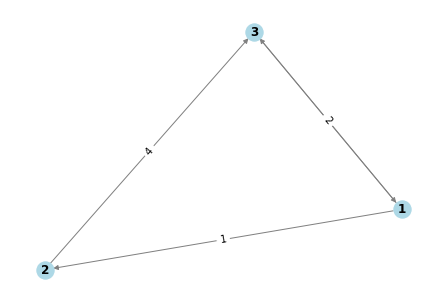

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph
G = nx.DiGraph()

# Add weighted edges to the graph
G.add_weighted_edges_from([(1, 2, 1), (1, 3, 5),(2, 3,4),(3, 1, 2)])

# Draw the graph
pos = nx.spring_layout(G)  # Specify the layout for the graph
labels = nx.get_edge_attributes(G, 'weight')  # Get the edge weights as labels
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels

# Display the graph
plt.show()


In [116]:

# Calculate the betweenness centrality with weights
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

# Calculate the current flow betweenness centrality with weights
# current_flow_centrality = nx.current_flow_betweenness_centrality(G, weight='weight')

# Print the centrality values
for node in G.nodes:
    print(f"Node {node}:")
    print(f"Betweenness Centrality: {betweenness_centrality[node]}")
#     print(f"Current Flow Centrality: {current_flow_centrality[node]}")
    print()

Node 1:
Betweenness Centrality: 0.5

Node 2:
Betweenness Centrality: 0.25

Node 3:
Betweenness Centrality: 0.5



## random walk betweenness centrality: can only for undirectly and connected network, so i get the largest component and. calculate it
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.current_flow_betweenness_centrality.html#networkx.algorithms.centrality.current_flow_betweenness_centrality

In [117]:
import networkx as nx


G = nx.Graph()
# G = nx.Graph()
G.add_nodes_from([1, 2, 3,4]) #4 is a disconnected node in the network
G.add_weighted_edges_from([(1, 2, 100), (2, 3,4),(1, 3,1)])

#get the largest component

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

centrality = nx.current_flow_betweenness_centrality(G0,weight='weight')
centrality
bc_centrality=nx.betweenness_centrality(G,weight='weight')
bc_centrality



{1: 0.0, 2: 0.0, 3: 0.3333333333333333, 4: 0.0}

In [118]:
import networkx as nx

# Create a directed graph
G = nx.Graph()
# G = nx.Graph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 100), (2, 3,4),(1, 3,1)])



# # Calculate the current flow betweenness centrality
centrality = nx.current_flow_betweenness_centrality(G, weight='weight')

# # centrality = nx.betweenness_centrality(G, weight='weight')

# Print the centrality values
for node, centrality_value in centrality.items():
    print(f"Node {node}: {centrality_value}")

Node 1: 0.19841269841269948
Node 2: 0.7936507936507975
Node 3: 0.007936507936507936


## reciprocity 

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.reciprocity.reciprocity.html#networkx.algorithms.reciprocity.reciprocity

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph
G = nx.DiGraph()

# Add weighted edges to the graph
G.add_weighted_edges_from([(1, 2, 1), (1, 3, 5),(2, 3,4),(2, 1, 1)])

In [23]:
reciprocity=nx.reciprocity(G)
reciprocity

0.5

In [24]:
# betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
# centrality_arr=np.array(list(nx.centrality.betweenness_centrality(G, weight = 'weight').values()))
# betweenness_centrality

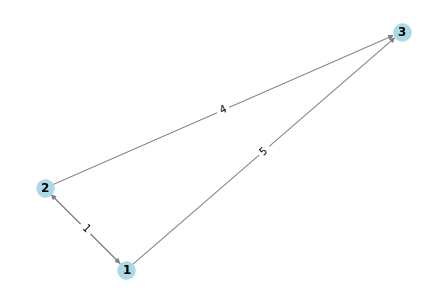

In [25]:
# Draw the graph
pos = nx.spring_layout(G)  # Specify the layout for the graph
labels = nx.get_edge_attributes(G, 'weight')  # Get the edge weights as labels
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels

# Display the graph
plt.show()


In [ ]:
#算法是一共四条边，两个方向的边是2条，所以是0.5




In [9]:
# centrality_arr

In [ ]:
#尝试编程用计算reciprocity for each nodes




In [57]:
#change to randome walk betweenness centrality , and add reciprocity

def calc_centrality_reciprocity(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False):
    '''
    calculate centralities
    
    
    adj_folder: where do you saved adj matrix
    centrality_folder: where do you want to save centrality data
    centrality: which centrality you want to calculate
    directed: directed graph or undirected graph
    weighted: weighted edges or edges are equally contributed
    ALPHA: a list of alpha factor to scale the adcacency matrix
    force_recalc: if True, recalculate even if the output file exist
    '''
    assert centrality in ['betweenness', 'closeness', 'degree','reciprocity','random_walk_bc'], 'not implemented'
    
    for file in tqdm(os.listdir(adj_folder)):
        
        if not file.endswith(".npz"):
            continue
        print(file)
        _, by, k = file[:-4].split('_')
        infile = adj_folder+'/'+file
        for alpha in ALPHA:
            outfile = centrality_folder+'/'+by+'_'+k+'_alpha_'+str(alpha)+'_'+centrality+'.npz'
            if force_recalc or not os.path.exists(outfile):
                if centrality=='random_walk_bc': #random_walk_bc only exists in undirected network
                    G = build_graph(infile, False, alpha, invalid_people_idx)
                    
                    #get the largest component
                    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
                    G0 = G.subgraph(Gcc[0])
                                       
                    if weighted:
                        centrality_arr= np.array(list(nx.current_flow_betweenness_centrality(G0, weight = 'weight').values()))
                    else:
                        centrality_arr= np.array(list(nx.current_flow_betweenness_centrality(G0).values()))
                    
                    
                else:
                    G = build_graph(infile, directed, alpha, invalid_people_idx)

                    if centrality == 'reciprocity':
                        centrality_arr=np.array(nx.reciprocity(G))

                    elif centrality == 'betweenness':
                        if weighted:
                            centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G, weight = 'weight').values()))
                        else:
                            centrality_arr = np.array(list(nx.centrality.betweenness_centrality(G).values()))
                    elif centrality == 'closeness':
                        if weighted:
                            centrality_arr = np.array(list(nx.centrality.closeness_centrality(G, distance = 'weight').values()))
                        else:
                            centrality_arr = np.array(list(nx.centrality.closeness_centrality(G).values()))
                    else:#degree centrality
                        centrality_arr = np.array(list(nx.centrality.degree_centrality(G).values()))
                centrality_arr_tosave = scipy.sparse.csc_matrix(centrality_arr)
                scipy.sparse.save_npz(outfile, centrality_arr_tosave)
                centrality_arr_tosave = None
                centrality_arr = None
                G = None
            else:
                print(f'outfile {outfile} found! Skipped!')


In [58]:
adj_folder

'./whole_adj'

In [83]:

# ALPHA=[1]


force_recalc=True

infile = "/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/adj_03212022/adjmat_month_49.npz"



G = build_graph(infile, directed, 1, invalid_people_idx)

centrality == 'reciprocity'
centrality_arr=np.array(nx.reciprocity(G))
print(centrality_arr)





            
            
            

0.011007911936704506


# 重新计算网络整体的reciprocity
用这里产生的reciprocity画出柱状图






In [87]:
import glob

force_recalc=True
filename2reciprocity={}

infile = "/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/adj_03212022/*.npz"

for file_path in glob.glob(infile):
#     print(file_path)
    file_name=file_path.split('/')[-1]
    print(file_name)

    G = build_graph(file_path, directed, 1, invalid_people_idx)

    centrality == 'reciprocity'
    centrality_arr=np.array(nx.reciprocity(G))
    filename2reciprocity[file_name]=centrality_arr
    print(file_name,": ",centrality_arr)






adjmat_stage_1.npz
adjmat_stage_1.npz :  0.04668337069761308
adjmat_month_0.npz
adjmat_month_0.npz :  0.0
adjmat_stage_0.npz
adjmat_stage_0.npz :  0.08074218165494539
adjmat_month_20.npz
adjmat_month_20.npz :  0.0
adjmat_month_36.npz
adjmat_month_36.npz :  0.0
adjmat_stage_2.npz
adjmat_stage_2.npz :  0.10660545779137975
adjmat_stage_3.npz
adjmat_stage_3.npz :  0.09872442200372043
adjmat_month_42.npz
adjmat_month_42.npz :  0.038461538461538464
adjmat_month_56.npz
adjmat_month_56.npz :  0.05401844532279315
adjmat_month_109.npz
adjmat_month_109.npz :  0.13291139240506328
adjmat_month_81.npz
adjmat_month_81.npz :  0.14676889375684557
adjmat_month_95.npz
adjmat_month_95.npz :  0.04190751445086705
adjmat_month_94.npz
adjmat_month_94.npz :  0.1248339973439575
adjmat_month_80.npz
adjmat_month_80.npz :  0.07636738906088751
adjmat_month_108.npz
adjmat_month_108.npz :  0.04504504504504504
adjmat_month_57.npz
adjmat_month_57.npz :  0.06014017635089306
adjmat_month_43.npz
adjmat_month_43.npz :  0.0

In [ ]:
filename2reciprocity

In [88]:
import pickle

# Dictionary to be saved

path='/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/reciprocity_test202306/'
# File path to save the dictionary
file_path = path+ "filename2reciprocity.pkl"

# Save the dictionary to a file using pickle
with open(file_path, "wb") as file:
    pickle.dump(filename2reciprocity, file)


In [90]:
filename2reciprocity

{'adjmat_stage_1.npz': array(0.04668337),
 'adjmat_month_0.npz': array(0.),
 'adjmat_stage_0.npz': array(0.08074218),
 'adjmat_month_20.npz': array(0.),
 'adjmat_month_36.npz': array(0.),
 'adjmat_stage_2.npz': array(0.10660546),
 'adjmat_stage_3.npz': array(0.09872442),
 'adjmat_month_42.npz': array(0.03846154),
 'adjmat_month_56.npz': array(0.05401845),
 'adjmat_month_109.npz': array(0.13291139),
 'adjmat_month_81.npz': array(0.14676889),
 'adjmat_month_95.npz': array(0.04190751),
 'adjmat_month_94.npz': array(0.124834),
 'adjmat_month_80.npz': array(0.07636739),
 'adjmat_month_108.npz': array(0.04504505),
 'adjmat_month_57.npz': array(0.06014018),
 'adjmat_month_43.npz': array(0.04347826),
 'adjmat_month_55.npz': array(0.05925251),
 'adjmat_month_41.npz': array(0.),
 'adjmat_month_69.npz': array(0.04713444),
 'adjmat_month_96.npz': array(0.05090909),
 'adjmat_month_82.npz': array(0.05879265),
 'adjmat_month_83.npz': array(0.14159292),
 'adjmat_month_97.npz': array(0.02252252),
 'adj

In [ ]:
#calculate the reciprocity for sinlge nodes

# node_id = 1
# reciprocity = nx.reciprocity(G, node_id)
# print(f"Reciprocity for node {node_id}: {reciprocity}")


In [ ]:
import pickle
import pandas as pd

# File path of the pickled dictionary


path='/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/reciprocity_test202306/'
# File path to save the dictionary
file_path = path+ "filename2reciprocity.pkl"


# Load the pickled dictionary
with open(file_path, "rb") as file:
    loaded_dict = pickle.load(file)

# Create a DataFrame from the loaded dictionary
reciprocity = pd.DataFrame.from_dict(loaded_dict, orient="index")
reciprocity=reciprocity.reset_index()
reciprocity=reciprocity.rename(columns={0:"network_reciprocity"})
# Print the DataFrame
# print(df)


In [ ]:

reciprocity2=reciprocity[reciprocity['index'].str.contains('month')]
reciprocity2=reciprocity2.reset_index(drop=True)

In [ ]:
#add a new column of month number
reciprocity2['month_number']=""
for i in range(len(reciprocity2)):
    monthi=reciprocity2['index'].iloc[i].split("_")[-1].split(".")[0]
    reciprocity2['month_number'].iloc[i]=int(monthi)
    




In [ ]:
# reciprocity3=reciprocity2.sort_values(by='month_number')
# reciprocity3.to_csv('network_reciprocity_for bar chart.csv',index=0)

In [92]:

#看看产生的文件里面是什么数字。。。



# import numpy as np
# import glob

# # Directory where the .npz files are located
# directory='/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/centrality_weighted_03212022/'


# # Search for .npz files with "reciprocity" in the file name
# file_pattern = directory + "*reciprocity.npz"

# # Get a list of matching file paths
# matching_files = glob.glob(file_pattern)

# # Loop through the matching files
# for file_path in matching_files:
# #     print(file_path)
    
#     data = scipy.sparse.load_npz(file_path)
#     data_dense = np.asarray(data.todense())

#     print(data_dense)

    # Access specific arrays within the .npz file if needed
    # For example, if the .npz file contains an array called 'arr':
    # arr = data['arr']


#这是错误的 数据，放弃使用




In [67]:
cd '/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/centrality_weighted_03212022'


/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/centrality_weighted_03212022


In [68]:
ls

all_0_alpha_1_closeness.npz           month_65_alpha_1_random_walk_bc.npz
month_0_alpha_1_betweenness.npz       month_65_alpha_1_reciprocity.npz
month_0_alpha_1_closeness.npz         month_66_alpha_1_betweenness.npz
month_0_alpha_1_degree.npz            month_66_alpha_1_closeness.npz
month_0_alpha_1_random_walk_bc.npz    month_66_alpha_1_degree.npz
month_0_alpha_1_reciprocity.npz       month_66_alpha_1_random_walk_bc.npz
month_100_alpha_1_betweenness.npz     month_66_alpha_1_reciprocity.npz
month_100_alpha_1_closeness.npz       month_67_alpha_1_betweenness.npz
month_100_alpha_1_degree.npz          month_67_alpha_1_closeness.npz
month_100_alpha_1_random_walk_bc.npz  month_67_alpha_1_degree.npz
month_100_alpha_1_reciprocity.npz     month_67_alpha_1_random_walk_bc.npz
month_101_alpha_1_betweenness.npz     month_67_alpha_1_reciprocity.npz
month_101_alpha_1_closeness.npz       month_68_alpha_1_betweenness.npz
month_101_alpha_1_degree.npz          month_68_alpha_1_closeness.npz
month_101_alp

# reciprocity for single nodes, not the whole network


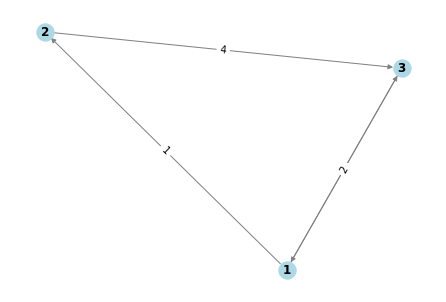

In [93]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph
G = nx.DiGraph()

# Add weighted edges to the graph
G.add_weighted_edges_from([(1, 2, 1), (1, 3, 5),(2, 3,4),(3, 1, 2)])

# Draw the graph
pos = nx.spring_layout(G)  # Specify the layout for the graph
labels = nx.get_edge_attributes(G, 'weight')  # Get the edge weights as labels
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels

# Display the graph
plt.show()


In [95]:
nx.reciprocity(G)

0.5

In [103]:
import networkx as nx

# Create a directed graph (DiGraph) using NetworkX
G = nx.DiGraph()

# Add weighted edges to the graph
G.add_weighted_edges_from([(1, 2, 1), (1, 3, 5),(2, 3,4),(3, 1, 2)])

# Calculate reciprocity for each individual node
node2reciprocity={}
for node in G.nodes():
    print(node)
    out_edges = set(G.successors(node))
    in_edges = set(G.predecessors(node))
    reciprocal_edges = out_edges.intersection(in_edges)
    total_out_edges = len(out_edges)
    if total_out_edges > 0:
        reciprocity = len(reciprocal_edges) / total_out_edges
    else:
        reciprocity = 0
    print(f"Reciprocity for node {node}: {reciprocity}",';reciprocal_edges: ',reciprocal_edges,';total_out_edges: ',total_out_edges)
    
    node2reciprocity[node]=reciprocity
    
    
    


1
Reciprocity for node 1: 0.5 ;reciprocal_edges:  {3} ;total_out_edges:  2
2
Reciprocity for node 2: 0.0 ;reciprocal_edges:  set() ;total_out_edges:  1
3
Reciprocity for node 3: 1.0 ;reciprocal_edges:  {1} ;total_out_edges:  1


In [104]:
node2reciprocity #建立reciprocity的dictionary


{1: 0.5, 2: 0.0, 3: 1.0}

In [120]:
pwd

'/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/centrality_weighted_03212022'

In [135]:
#测试单个文件


# ALPHA=[1]


force_recalc=True

infile = "/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206/adj_03212022/adjmat_month_108.npz"



G = build_graph(infile, directed, 1, invalid_people_idx)
node2reciprocity={}
for node in G.nodes():
    print(node)
    out_edges = set(G.successors(node))
    in_edges = set(G.predecessors(node))
    reciprocal_edges = out_edges.intersection(in_edges)
    total_out_edges = len(out_edges)
    if total_out_edges > 0:
        reciprocity = len(reciprocal_edges) / total_out_edges
    else:
        reciprocity = 0
    print(f"Reciprocity for node {node}: {reciprocity}",';reciprocal_edges: ',reciprocal_edges,';total_out_edges: ',total_out_edges)
    
    node2reciprocity[node]=reciprocity
    








0
Reciprocity for node 0: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1
Reciprocity for node 1: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2
Reciprocity for node 2: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3
Reciprocity for node 3: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4
Reciprocity for node 4: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5
Reciprocity for node 5: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6
Reciprocity for node 6: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7
Reciprocity for node 7: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8
Reciprocity for node 8: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9
Reciprocity for node 9: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10
Reciprocity for node 10: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11
Reciprocity for node 11: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12
Reciprocity for node 12: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13
Reciprocity for 

Reciprocity for node 349: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
350
Reciprocity for node 350: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
351
Reciprocity for node 351: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
352
Reciprocity for node 352: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
353
Reciprocity for node 353: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
354
Reciprocity for node 354: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
355
Reciprocity for node 355: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
356
Reciprocity for node 356: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
357
Reciprocity for node 357: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
358
Reciprocity for node 358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
359
Reciprocity for node 359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
360
Reciprocity for node 360: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
361
Reciprocity for node 361: 0 ;reciprocal_edges:  set(

Reciprocity for node 682: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
683
Reciprocity for node 683: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
684
Reciprocity for node 684: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
685
Reciprocity for node 685: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
686
Reciprocity for node 686: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
687
Reciprocity for node 687: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
688
Reciprocity for node 688: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
689
Reciprocity for node 689: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
690
Reciprocity for node 690: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
691
Reciprocity for node 691: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
692
Reciprocity for node 692: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
693
Reciprocity for node 693: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
694
Reciprocity for node 694: 0 ;reciprocal_edges:  set(

1016
Reciprocity for node 1016: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1017
Reciprocity for node 1017: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1018
Reciprocity for node 1018: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1019
Reciprocity for node 1019: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1020
Reciprocity for node 1020: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1021
Reciprocity for node 1021: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1022
Reciprocity for node 1022: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1023
Reciprocity for node 1023: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1024
Reciprocity for node 1024: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1025
Reciprocity for node 1025: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1026
Reciprocity for node 1026: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1027
Reciprocity for node 1027: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1028
Reciprocity for node 10

Reciprocity for node 1349: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1350
Reciprocity for node 1350: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1351
Reciprocity for node 1351: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1352
Reciprocity for node 1352: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1353
Reciprocity for node 1353: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1354
Reciprocity for node 1354: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1355
Reciprocity for node 1355: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1356
Reciprocity for node 1356: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1357
Reciprocity for node 1357: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1358
Reciprocity for node 1358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1359
Reciprocity for node 1359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1360
Reciprocity for node 1360: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1361
Reciprocity for node 1361: 0

Reciprocity for node 1682: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1683
Reciprocity for node 1683: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1684
Reciprocity for node 1684: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1685
Reciprocity for node 1685: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1686
Reciprocity for node 1686: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1687
Reciprocity for node 1687: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1688
Reciprocity for node 1688: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1689
Reciprocity for node 1689: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1690
Reciprocity for node 1690: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1691
Reciprocity for node 1691: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1692
Reciprocity for node 1692: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1693
Reciprocity for node 1693: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1694
Reciprocity for node 1694: 0

Reciprocity for node 2027: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2028
Reciprocity for node 2028: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2029
Reciprocity for node 2029: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2030
Reciprocity for node 2030: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2031
Reciprocity for node 2031: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2032
Reciprocity for node 2032: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2033
Reciprocity for node 2033: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2034
Reciprocity for node 2034: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2035
Reciprocity for node 2035: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2036
Reciprocity for node 2036: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2037
Reciprocity for node 2037: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2038
Reciprocity for node 2038: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2039
Reciprocity for node 2039: 0

Reciprocity for node 2415: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2416
Reciprocity for node 2416: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2417
Reciprocity for node 2417: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2418
Reciprocity for node 2418: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2419
Reciprocity for node 2419: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2420
Reciprocity for node 2420: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2421
Reciprocity for node 2421: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2422
Reciprocity for node 2422: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2423
Reciprocity for node 2423: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2424
Reciprocity for node 2424: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2425
Reciprocity for node 2425: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2426
Reciprocity for node 2426: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2427
Reciprocity for node 2427: 0

Reciprocity for node 2736: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2737
Reciprocity for node 2737: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2738
Reciprocity for node 2738: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2739
Reciprocity for node 2739: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2740
Reciprocity for node 2740: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2741
Reciprocity for node 2741: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2742
Reciprocity for node 2742: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2743
Reciprocity for node 2743: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2744
Reciprocity for node 2744: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2745
Reciprocity for node 2745: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2746
Reciprocity for node 2746: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2747
Reciprocity for node 2747: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2748
Reciprocity for node 2748: 0

Reciprocity for node 3048: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3049
Reciprocity for node 3049: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3050
Reciprocity for node 3050: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3051
Reciprocity for node 3051: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3052
Reciprocity for node 3052: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3053
Reciprocity for node 3053: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3054
Reciprocity for node 3054: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3055
Reciprocity for node 3055: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3056
Reciprocity for node 3056: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3057
Reciprocity for node 3057: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3058
Reciprocity for node 3058: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3059
Reciprocity for node 3059: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3060
Reciprocity for node 3060: 0

Reciprocity for node 3348: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3349
Reciprocity for node 3349: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3350
Reciprocity for node 3350: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3351
Reciprocity for node 3351: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3352
Reciprocity for node 3352: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3353
Reciprocity for node 3353: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3354
Reciprocity for node 3354: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3355
Reciprocity for node 3355: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3356
Reciprocity for node 3356: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3357
Reciprocity for node 3357: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3358
Reciprocity for node 3358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3359
Reciprocity for node 3359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3360
Reciprocity for node 3360: 0

3682
Reciprocity for node 3682: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3683
Reciprocity for node 3683: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3684
Reciprocity for node 3684: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3685
Reciprocity for node 3685: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3686
Reciprocity for node 3686: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3687
Reciprocity for node 3687: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3688
Reciprocity for node 3688: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3689
Reciprocity for node 3689: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3690
Reciprocity for node 3690: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3691
Reciprocity for node 3691: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3692
Reciprocity for node 3692: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3693
Reciprocity for node 3693: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
3694
Reciprocity for node 36

Reciprocity for node 4015: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4016
Reciprocity for node 4016: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4017
Reciprocity for node 4017: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4018
Reciprocity for node 4018: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4019
Reciprocity for node 4019: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4020
Reciprocity for node 4020: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4021
Reciprocity for node 4021: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4022
Reciprocity for node 4022: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4023
Reciprocity for node 4023: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4024
Reciprocity for node 4024: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4025
Reciprocity for node 4025: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4026
Reciprocity for node 4026: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4027
Reciprocity for node 4027: 0

Reciprocity for node 4348: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4349
Reciprocity for node 4349: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4350
Reciprocity for node 4350: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4351
Reciprocity for node 4351: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4352
Reciprocity for node 4352: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4353
Reciprocity for node 4353: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4354
Reciprocity for node 4354: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4355
Reciprocity for node 4355: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4356
Reciprocity for node 4356: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4357
Reciprocity for node 4357: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4358
Reciprocity for node 4358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4359
Reciprocity for node 4359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4360
Reciprocity for node 4360: 0

Reciprocity for node 4728: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4729
Reciprocity for node 4729: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4730
Reciprocity for node 4730: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4731
Reciprocity for node 4731: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4732
Reciprocity for node 4732: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4733
Reciprocity for node 4733: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4734
Reciprocity for node 4734: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4735
Reciprocity for node 4735: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4736
Reciprocity for node 4736: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4737
Reciprocity for node 4737: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4738
Reciprocity for node 4738: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4739
Reciprocity for node 4739: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
4740
Reciprocity for node 4740: 0

Reciprocity for node 5058: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5059
Reciprocity for node 5059: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5060
Reciprocity for node 5060: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5061
Reciprocity for node 5061: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5062
Reciprocity for node 5062: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5063
Reciprocity for node 5063: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5064
Reciprocity for node 5064: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5065
Reciprocity for node 5065: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5066
Reciprocity for node 5066: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5067
Reciprocity for node 5067: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5068
Reciprocity for node 5068: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5069
Reciprocity for node 5069: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5070
Reciprocity for node 5070: 0

5384
Reciprocity for node 5384: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5385
Reciprocity for node 5385: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5386
Reciprocity for node 5386: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5387
Reciprocity for node 5387: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5388
Reciprocity for node 5388: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5389
Reciprocity for node 5389: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5390
Reciprocity for node 5390: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5391
Reciprocity for node 5391: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5392
Reciprocity for node 5392: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5393
Reciprocity for node 5393: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5394
Reciprocity for node 5394: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5395
Reciprocity for node 5395: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5396
Reciprocity for node 53

Reciprocity for node 5744: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5745
Reciprocity for node 5745: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5746
Reciprocity for node 5746: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5747
Reciprocity for node 5747: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5748
Reciprocity for node 5748: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5749
Reciprocity for node 5749: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5750
Reciprocity for node 5750: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5751
Reciprocity for node 5751: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5752
Reciprocity for node 5752: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5753
Reciprocity for node 5753: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5754
Reciprocity for node 5754: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5755
Reciprocity for node 5755: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
5756
Reciprocity for node 5756: 0

Reciprocity for node 6010: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6011
Reciprocity for node 6011: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6012
Reciprocity for node 6012: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6013
Reciprocity for node 6013: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6014
Reciprocity for node 6014: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6015
Reciprocity for node 6015: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6016
Reciprocity for node 6016: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6017
Reciprocity for node 6017: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6018
Reciprocity for node 6018: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6019
Reciprocity for node 6019: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6020
Reciprocity for node 6020: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6021
Reciprocity for node 6021: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6022
Reciprocity for node 6022: 0

Reciprocity for node 6208: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6209
Reciprocity for node 6209: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6210
Reciprocity for node 6210: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6211
Reciprocity for node 6211: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6212
Reciprocity for node 6212: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6213
Reciprocity for node 6213: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6214
Reciprocity for node 6214: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6215
Reciprocity for node 6215: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6216
Reciprocity for node 6216: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6217
Reciprocity for node 6217: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6218
Reciprocity for node 6218: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6219
Reciprocity for node 6219: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6220
Reciprocity for node 6220: 0

Reciprocity for node 6534: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6535
Reciprocity for node 6535: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6536
Reciprocity for node 6536: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6537
Reciprocity for node 6537: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6538
Reciprocity for node 6538: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6539
Reciprocity for node 6539: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6540
Reciprocity for node 6540: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6541
Reciprocity for node 6541: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6542
Reciprocity for node 6542: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6543
Reciprocity for node 6543: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6544
Reciprocity for node 6544: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6545
Reciprocity for node 6545: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6546
Reciprocity for node 6546: 0

6874
Reciprocity for node 6874: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6875
Reciprocity for node 6875: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6876
Reciprocity for node 6876: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6877
Reciprocity for node 6877: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6878
Reciprocity for node 6878: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6879
Reciprocity for node 6879: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6880
Reciprocity for node 6880: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6881
Reciprocity for node 6881: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6882
Reciprocity for node 6882: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6883
Reciprocity for node 6883: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6884
Reciprocity for node 6884: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6885
Reciprocity for node 6885: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
6886
Reciprocity for node 68

Reciprocity for node 7210: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7211
Reciprocity for node 7211: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7212
Reciprocity for node 7212: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7213
Reciprocity for node 7213: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7214
Reciprocity for node 7214: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7215
Reciprocity for node 7215: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7216
Reciprocity for node 7216: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7217
Reciprocity for node 7217: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7218
Reciprocity for node 7218: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7219
Reciprocity for node 7219: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7220
Reciprocity for node 7220: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7221
Reciprocity for node 7221: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7222
Reciprocity for node 7222: 0

7527
Reciprocity for node 7527: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7528
Reciprocity for node 7528: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7529
Reciprocity for node 7529: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7530
Reciprocity for node 7530: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7531
Reciprocity for node 7531: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7532
Reciprocity for node 7532: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7533
Reciprocity for node 7533: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7534
Reciprocity for node 7534: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7535
Reciprocity for node 7535: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7536
Reciprocity for node 7536: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7537
Reciprocity for node 7537: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7538
Reciprocity for node 7538: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7539
Reciprocity for node 75

Reciprocity for node 7847: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7848
Reciprocity for node 7848: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7849
Reciprocity for node 7849: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7850
Reciprocity for node 7850: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7851
Reciprocity for node 7851: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7852
Reciprocity for node 7852: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7853
Reciprocity for node 7853: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7854
Reciprocity for node 7854: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7855
Reciprocity for node 7855: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7856
Reciprocity for node 7856: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7857
Reciprocity for node 7857: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7858
Reciprocity for node 7858: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
7859
Reciprocity for node 7859: 0

Reciprocity for node 8160: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8161
Reciprocity for node 8161: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8162
Reciprocity for node 8162: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8163
Reciprocity for node 8163: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8164
Reciprocity for node 8164: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8165
Reciprocity for node 8165: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8166
Reciprocity for node 8166: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8167
Reciprocity for node 8167: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8168
Reciprocity for node 8168: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8169
Reciprocity for node 8169: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8170
Reciprocity for node 8170: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8171
Reciprocity for node 8171: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8172
Reciprocity for node 8172: 0

Reciprocity for node 8472: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8473
Reciprocity for node 8473: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8474
Reciprocity for node 8474: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8475
Reciprocity for node 8475: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8476
Reciprocity for node 8476: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8477
Reciprocity for node 8477: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8478
Reciprocity for node 8478: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8479
Reciprocity for node 8479: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8480
Reciprocity for node 8480: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8481
Reciprocity for node 8481: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8482
Reciprocity for node 8482: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8483
Reciprocity for node 8483: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8484
Reciprocity for node 8484: 0

Reciprocity for node 8762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8763
Reciprocity for node 8763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8764
Reciprocity for node 8764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8765
Reciprocity for node 8765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8766
Reciprocity for node 8766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8767
Reciprocity for node 8767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8768
Reciprocity for node 8768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8769
Reciprocity for node 8769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8770
Reciprocity for node 8770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8771
Reciprocity for node 8771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8772
Reciprocity for node 8772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8773
Reciprocity for node 8773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
8774
Reciprocity for node 8774: 0

Reciprocity for node 9099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9100
Reciprocity for node 9100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9101
Reciprocity for node 9101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9102
Reciprocity for node 9102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9103
Reciprocity for node 9103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9104
Reciprocity for node 9104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9105
Reciprocity for node 9105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9106
Reciprocity for node 9106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9107
Reciprocity for node 9107: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9108
Reciprocity for node 9108: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9109
Reciprocity for node 9109: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9110
Reciprocity for node 9110: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9111
Reciprocity for node 9111: 0

Reciprocity for node 9426: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9427
Reciprocity for node 9427: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9428
Reciprocity for node 9428: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9429
Reciprocity for node 9429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9430
Reciprocity for node 9430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9431
Reciprocity for node 9431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9432
Reciprocity for node 9432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9433
Reciprocity for node 9433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9434
Reciprocity for node 9434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9435
Reciprocity for node 9435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9436
Reciprocity for node 9436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9437
Reciprocity for node 9437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9438
Reciprocity for node 9438: 0

Reciprocity for node 9788: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9789
Reciprocity for node 9789: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9790
Reciprocity for node 9790: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9791
Reciprocity for node 9791: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9792
Reciprocity for node 9792: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9793
Reciprocity for node 9793: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9794
Reciprocity for node 9794: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9795
Reciprocity for node 9795: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9796
Reciprocity for node 9796: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9797
Reciprocity for node 9797: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9798
Reciprocity for node 9798: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9799
Reciprocity for node 9799: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
9800
Reciprocity for node 9800: 0

Reciprocity for node 10078: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10079
Reciprocity for node 10079: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10080
Reciprocity for node 10080: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10081
Reciprocity for node 10081: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10082
Reciprocity for node 10082: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10083
Reciprocity for node 10083: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10084
Reciprocity for node 10084: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10085
Reciprocity for node 10085: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10086
Reciprocity for node 10086: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10087
Reciprocity for node 10087: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10088
Reciprocity for node 10088: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10089
Reciprocity for node 10089: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10090
Reci

Reciprocity for node 10380: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10381
Reciprocity for node 10381: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10382
Reciprocity for node 10382: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10383
Reciprocity for node 10383: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10384
Reciprocity for node 10384: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10385
Reciprocity for node 10385: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10386
Reciprocity for node 10386: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10387
Reciprocity for node 10387: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10388
Reciprocity for node 10388: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10389
Reciprocity for node 10389: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10390
Reciprocity for node 10390: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10391
Reciprocity for node 10391: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10392
Reci

Reciprocity for node 10771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10772
Reciprocity for node 10772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10773
Reciprocity for node 10773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10774
Reciprocity for node 10774: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10775
Reciprocity for node 10775: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10776
Reciprocity for node 10776: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10777
Reciprocity for node 10777: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10778
Reciprocity for node 10778: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10779
Reciprocity for node 10779: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10780
Reciprocity for node 10780: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10781
Reciprocity for node 10781: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10782
Reciprocity for node 10782: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
10783
Reci

Reciprocity for node 11107: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11108
Reciprocity for node 11108: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11109
Reciprocity for node 11109: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11110
Reciprocity for node 11110: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11111
Reciprocity for node 11111: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11112
Reciprocity for node 11112: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11113
Reciprocity for node 11113: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11114
Reciprocity for node 11114: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11115
Reciprocity for node 11115: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11116
Reciprocity for node 11116: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11117
Reciprocity for node 11117: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11118
Reciprocity for node 11118: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11119
Reci

11430
Reciprocity for node 11430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11431
Reciprocity for node 11431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11432
Reciprocity for node 11432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11433
Reciprocity for node 11433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11434
Reciprocity for node 11434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11435
Reciprocity for node 11435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11436
Reciprocity for node 11436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11437
Reciprocity for node 11437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11438
Reciprocity for node 11438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11439
Reciprocity for node 11439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11440
Reciprocity for node 11440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11441
Reciprocity for node 11441: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1144

Reciprocity for node 11763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11764
Reciprocity for node 11764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11765
Reciprocity for node 11765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11766
Reciprocity for node 11766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11767
Reciprocity for node 11767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11768
Reciprocity for node 11768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11769
Reciprocity for node 11769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11770
Reciprocity for node 11770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11771
Reciprocity for node 11771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11772
Reciprocity for node 11772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11773
Reciprocity for node 11773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11774
Reciprocity for node 11774: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
11775
Reci

Reciprocity for node 12096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12097
Reciprocity for node 12097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12098
Reciprocity for node 12098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12099
Reciprocity for node 12099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12100
Reciprocity for node 12100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12101
Reciprocity for node 12101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12102
Reciprocity for node 12102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12103
Reciprocity for node 12103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12104
Reciprocity for node 12104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12105
Reciprocity for node 12105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12106
Reciprocity for node 12106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12107
Reciprocity for node 12107: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12108
Reci

Reciprocity for node 12429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12430
Reciprocity for node 12430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12431
Reciprocity for node 12431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12432
Reciprocity for node 12432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12433
Reciprocity for node 12433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12434
Reciprocity for node 12434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12435
Reciprocity for node 12435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12436
Reciprocity for node 12436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12437
Reciprocity for node 12437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12438
Reciprocity for node 12438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12439
Reciprocity for node 12439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12440
Reciprocity for node 12440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12441
Reci

12763
Reciprocity for node 12763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12764
Reciprocity for node 12764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12765
Reciprocity for node 12765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12766
Reciprocity for node 12766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12767
Reciprocity for node 12767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12768
Reciprocity for node 12768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12769
Reciprocity for node 12769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12770
Reciprocity for node 12770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12771
Reciprocity for node 12771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12772
Reciprocity for node 12772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12773
Reciprocity for node 12773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
12774
Reciprocity for node 12774: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1277

Reciprocity for node 13103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13104
Reciprocity for node 13104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13105
Reciprocity for node 13105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13106
Reciprocity for node 13106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13107
Reciprocity for node 13107: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13108
Reciprocity for node 13108: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13109
Reciprocity for node 13109: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13110
Reciprocity for node 13110: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13111
Reciprocity for node 13111: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13112
Reciprocity for node 13112: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13113
Reciprocity for node 13113: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13114
Reciprocity for node 13114: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13115
Reci

Reciprocity for node 13429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13430
Reciprocity for node 13430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13431
Reciprocity for node 13431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13432
Reciprocity for node 13432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13433
Reciprocity for node 13433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13434
Reciprocity for node 13434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13435
Reciprocity for node 13435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13436
Reciprocity for node 13436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13437
Reciprocity for node 13437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13438
Reciprocity for node 13438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13439
Reciprocity for node 13439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13440
Reciprocity for node 13440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13441
Reci

Reciprocity for node 13762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13763
Reciprocity for node 13763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13764
Reciprocity for node 13764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13765
Reciprocity for node 13765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13766
Reciprocity for node 13766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13767
Reciprocity for node 13767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13768
Reciprocity for node 13768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13769
Reciprocity for node 13769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13770
Reciprocity for node 13770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13771
Reciprocity for node 13771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13772
Reciprocity for node 13772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13773
Reciprocity for node 13773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
13774
Reci

14096
Reciprocity for node 14096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14097
Reciprocity for node 14097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14098
Reciprocity for node 14098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14099
Reciprocity for node 14099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14100
Reciprocity for node 14100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14101
Reciprocity for node 14101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14102
Reciprocity for node 14102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14103
Reciprocity for node 14103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14104
Reciprocity for node 14104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14105
Reciprocity for node 14105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14106
Reciprocity for node 14106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14107
Reciprocity for node 14107: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1410

Reciprocity for node 14429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14430
Reciprocity for node 14430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14431
Reciprocity for node 14431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14432
Reciprocity for node 14432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14433
Reciprocity for node 14433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14434
Reciprocity for node 14434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14435
Reciprocity for node 14435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14436
Reciprocity for node 14436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14437
Reciprocity for node 14437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14438
Reciprocity for node 14438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14439
Reciprocity for node 14439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14440
Reciprocity for node 14440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14441
Reci

Reciprocity for node 14762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14763
Reciprocity for node 14763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14764
Reciprocity for node 14764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14765
Reciprocity for node 14765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14766
Reciprocity for node 14766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14767
Reciprocity for node 14767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14768
Reciprocity for node 14768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14769
Reciprocity for node 14769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14770
Reciprocity for node 14770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14771
Reciprocity for node 14771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14772
Reciprocity for node 14772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14773
Reciprocity for node 14773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
14774
Reci

Reciprocity for node 15095: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15096
Reciprocity for node 15096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15097
Reciprocity for node 15097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15098
Reciprocity for node 15098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15099
Reciprocity for node 15099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15100
Reciprocity for node 15100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15101
Reciprocity for node 15101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15102
Reciprocity for node 15102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15103
Reciprocity for node 15103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15104
Reciprocity for node 15104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15105
Reciprocity for node 15105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15106
Reciprocity for node 15106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15107
Reci

15429
Reciprocity for node 15429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15430
Reciprocity for node 15430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15431
Reciprocity for node 15431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15432
Reciprocity for node 15432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15433
Reciprocity for node 15433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15434
Reciprocity for node 15434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15435
Reciprocity for node 15435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15436
Reciprocity for node 15436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15437
Reciprocity for node 15437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15438
Reciprocity for node 15438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15439
Reciprocity for node 15439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15440
Reciprocity for node 15440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1544

Reciprocity for node 15762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15763
Reciprocity for node 15763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15764
Reciprocity for node 15764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15765
Reciprocity for node 15765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15766
Reciprocity for node 15766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15767
Reciprocity for node 15767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15768
Reciprocity for node 15768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15769
Reciprocity for node 15769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15770
Reciprocity for node 15770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15771
Reciprocity for node 15771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15772
Reciprocity for node 15772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15773
Reciprocity for node 15773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
15774
Reci

Reciprocity for node 16095: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16096
Reciprocity for node 16096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16097
Reciprocity for node 16097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16098
Reciprocity for node 16098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16099
Reciprocity for node 16099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16100
Reciprocity for node 16100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16101
Reciprocity for node 16101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16102
Reciprocity for node 16102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16103
Reciprocity for node 16103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16104
Reciprocity for node 16104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16105
Reciprocity for node 16105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16106
Reciprocity for node 16106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16107
Reci

Reciprocity for node 16428: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16429
Reciprocity for node 16429: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16430
Reciprocity for node 16430: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16431
Reciprocity for node 16431: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16432
Reciprocity for node 16432: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16433
Reciprocity for node 16433: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16434
Reciprocity for node 16434: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16435
Reciprocity for node 16435: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16436
Reciprocity for node 16436: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16437
Reciprocity for node 16437: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16438
Reciprocity for node 16438: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16439
Reciprocity for node 16439: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16440
Reci

16762
Reciprocity for node 16762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16763
Reciprocity for node 16763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16764
Reciprocity for node 16764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16765
Reciprocity for node 16765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16766
Reciprocity for node 16766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16767
Reciprocity for node 16767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16768
Reciprocity for node 16768: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16769
Reciprocity for node 16769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16770
Reciprocity for node 16770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16771
Reciprocity for node 16771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16772
Reciprocity for node 16772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
16773
Reciprocity for node 16773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1677

Reciprocity for node 17095: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17096
Reciprocity for node 17096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17097
Reciprocity for node 17097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17098
Reciprocity for node 17098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17099
Reciprocity for node 17099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17100
Reciprocity for node 17100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17101
Reciprocity for node 17101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17102
Reciprocity for node 17102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17103
Reciprocity for node 17103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17104
Reciprocity for node 17104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17105
Reciprocity for node 17105: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17106
Reciprocity for node 17106: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17107
Reci

Reciprocity for node 17440: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17441
Reciprocity for node 17441: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17442
Reciprocity for node 17442: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17443
Reciprocity for node 17443: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17444
Reciprocity for node 17444: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17445
Reciprocity for node 17445: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17446
Reciprocity for node 17446: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17447
Reciprocity for node 17447: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17448
Reciprocity for node 17448: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17449
Reciprocity for node 17449: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17450
Reciprocity for node 17450: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17451
Reciprocity for node 17451: 0.0 ;reciprocal_edges:  set() ;total_out_edges:  1
17452
Re

Reciprocity for node 17769: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17770
Reciprocity for node 17770: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17771
Reciprocity for node 17771: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17772
Reciprocity for node 17772: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17773
Reciprocity for node 17773: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17774
Reciprocity for node 17774: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17775
Reciprocity for node 17775: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17776
Reciprocity for node 17776: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17777
Reciprocity for node 17777: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17778
Reciprocity for node 17778: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17779
Reciprocity for node 17779: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17780
Reciprocity for node 17780: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
17781
Reci

Reciprocity for node 18117: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18118
Reciprocity for node 18118: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18119
Reciprocity for node 18119: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18120
Reciprocity for node 18120: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18121
Reciprocity for node 18121: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18122
Reciprocity for node 18122: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18123
Reciprocity for node 18123: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18124
Reciprocity for node 18124: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18125
Reciprocity for node 18125: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18126
Reciprocity for node 18126: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18127
Reciprocity for node 18127: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18128
Reciprocity for node 18128: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18129
Reci

Reciprocity for node 18448: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18449
Reciprocity for node 18449: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18450
Reciprocity for node 18450: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18451
Reciprocity for node 18451: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18452
Reciprocity for node 18452: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18453
Reciprocity for node 18453: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18454
Reciprocity for node 18454: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18455
Reciprocity for node 18455: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18456
Reciprocity for node 18456: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18457
Reciprocity for node 18457: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18458
Reciprocity for node 18458: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18459
Reciprocity for node 18459: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18460
Reci

18790
Reciprocity for node 18790: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18791
Reciprocity for node 18791: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18792
Reciprocity for node 18792: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18793
Reciprocity for node 18793: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18794
Reciprocity for node 18794: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18795
Reciprocity for node 18795: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18796
Reciprocity for node 18796: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18797
Reciprocity for node 18797: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18798
Reciprocity for node 18798: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18799
Reciprocity for node 18799: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18800
Reciprocity for node 18800: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
18801
Reciprocity for node 18801: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1880

Reciprocity for node 19118: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19119
Reciprocity for node 19119: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19120
Reciprocity for node 19120: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19121
Reciprocity for node 19121: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19122
Reciprocity for node 19122: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19123
Reciprocity for node 19123: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19124
Reciprocity for node 19124: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19125
Reciprocity for node 19125: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19126
Reciprocity for node 19126: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19127
Reciprocity for node 19127: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19128
Reciprocity for node 19128: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19129
Reciprocity for node 19129: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19130
Reci

19444
Reciprocity for node 19444: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19445
Reciprocity for node 19445: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19446
Reciprocity for node 19446: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19447
Reciprocity for node 19447: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19448
Reciprocity for node 19448: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19449
Reciprocity for node 19449: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19450
Reciprocity for node 19450: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19451
Reciprocity for node 19451: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19452
Reciprocity for node 19452: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19453
Reciprocity for node 19453: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19454
Reciprocity for node 19454: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19455
Reciprocity for node 19455: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1945

19756
Reciprocity for node 19756: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19757
Reciprocity for node 19757: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19758
Reciprocity for node 19758: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19759
Reciprocity for node 19759: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19760
Reciprocity for node 19760: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19761
Reciprocity for node 19761: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19762
Reciprocity for node 19762: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19763
Reciprocity for node 19763: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19764
Reciprocity for node 19764: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19765
Reciprocity for node 19765: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19766
Reciprocity for node 19766: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
19767
Reciprocity for node 19767: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
1976

Reciprocity for node 20093: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20094
Reciprocity for node 20094: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20095
Reciprocity for node 20095: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20096
Reciprocity for node 20096: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20097
Reciprocity for node 20097: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20098
Reciprocity for node 20098: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20099
Reciprocity for node 20099: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20100
Reciprocity for node 20100: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20101
Reciprocity for node 20101: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20102
Reciprocity for node 20102: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20103
Reciprocity for node 20103: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20104
Reciprocity for node 20104: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20105
Reci

Reciprocity for node 20374: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20375
Reciprocity for node 20375: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20376
Reciprocity for node 20376: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20377
Reciprocity for node 20377: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20378
Reciprocity for node 20378: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20379
Reciprocity for node 20379: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20380
Reciprocity for node 20380: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20381
Reciprocity for node 20381: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20382
Reciprocity for node 20382: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20383
Reciprocity for node 20383: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20384
Reciprocity for node 20384: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20385
Reciprocity for node 20385: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20386
Reci

Reciprocity for node 20677: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20678
Reciprocity for node 20678: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20679
Reciprocity for node 20679: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20680
Reciprocity for node 20680: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20681
Reciprocity for node 20681: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20682
Reciprocity for node 20682: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20683
Reciprocity for node 20683: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20684
Reciprocity for node 20684: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20685
Reciprocity for node 20685: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20686
Reciprocity for node 20686: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20687
Reciprocity for node 20687: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20688
Reciprocity for node 20688: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20689
Reci

20998
Reciprocity for node 20998: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
20999
Reciprocity for node 20999: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21000
Reciprocity for node 21000: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21001
Reciprocity for node 21001: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21002
Reciprocity for node 21002: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21003
Reciprocity for node 21003: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21004
Reciprocity for node 21004: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21005
Reciprocity for node 21005: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21006
Reciprocity for node 21006: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21007
Reciprocity for node 21007: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21008
Reciprocity for node 21008: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21009
Reciprocity for node 21009: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2101

Reciprocity for node 21349: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21350
Reciprocity for node 21350: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21351
Reciprocity for node 21351: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21352
Reciprocity for node 21352: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21353
Reciprocity for node 21353: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21354
Reciprocity for node 21354: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21355
Reciprocity for node 21355: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21356
Reciprocity for node 21356: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21357
Reciprocity for node 21357: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21358
Reciprocity for node 21358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21359
Reciprocity for node 21359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21360
Reciprocity for node 21360: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21361
Reci

21646
Reciprocity for node 21646: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21647
Reciprocity for node 21647: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21648
Reciprocity for node 21648: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21649
Reciprocity for node 21649: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21650
Reciprocity for node 21650: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21651
Reciprocity for node 21651: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21652
Reciprocity for node 21652: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21653
Reciprocity for node 21653: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21654
Reciprocity for node 21654: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21655
Reciprocity for node 21655: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21656
Reciprocity for node 21656: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21657
Reciprocity for node 21657: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2165

Reciprocity for node 21983: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21984
Reciprocity for node 21984: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21985
Reciprocity for node 21985: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21986
Reciprocity for node 21986: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21987
Reciprocity for node 21987: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21988
Reciprocity for node 21988: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21989
Reciprocity for node 21989: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21990
Reciprocity for node 21990: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21991
Reciprocity for node 21991: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21992
Reciprocity for node 21992: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21993
Reciprocity for node 21993: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21994
Reciprocity for node 21994: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
21995
Reci

Reciprocity for node 22331: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22332
Reciprocity for node 22332: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22333
Reciprocity for node 22333: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22334
Reciprocity for node 22334: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22335
Reciprocity for node 22335: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22336
Reciprocity for node 22336: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22337
Reciprocity for node 22337: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22338
Reciprocity for node 22338: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22339
Reciprocity for node 22339: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22340
Reciprocity for node 22340: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22341
Reciprocity for node 22341: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22342
Reciprocity for node 22342: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22343
Reci

22612
Reciprocity for node 22612: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22613
Reciprocity for node 22613: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22614
Reciprocity for node 22614: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22615
Reciprocity for node 22615: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22616
Reciprocity for node 22616: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22617
Reciprocity for node 22617: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22618
Reciprocity for node 22618: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22619
Reciprocity for node 22619: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22620
Reciprocity for node 22620: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22621
Reciprocity for node 22621: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22622
Reciprocity for node 22622: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
22623
Reciprocity for node 22623: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2262

Reciprocity for node 23016: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23017
Reciprocity for node 23017: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23018
Reciprocity for node 23018: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23019
Reciprocity for node 23019: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23020
Reciprocity for node 23020: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23021
Reciprocity for node 23021: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23022
Reciprocity for node 23022: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23023
Reciprocity for node 23023: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23024
Reciprocity for node 23024: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23025
Reciprocity for node 23025: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23026
Reciprocity for node 23026: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23027
Reciprocity for node 23027: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23028
Reci

23374
Reciprocity for node 23374: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23375
Reciprocity for node 23375: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23376
Reciprocity for node 23376: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23377
Reciprocity for node 23377: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23378
Reciprocity for node 23378: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23379
Reciprocity for node 23379: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23380
Reciprocity for node 23380: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23381
Reciprocity for node 23381: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23382
Reciprocity for node 23382: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23383
Reciprocity for node 23383: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23384
Reciprocity for node 23384: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23385
Reciprocity for node 23385: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2338

Reciprocity for node 23732: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23733
Reciprocity for node 23733: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23734
Reciprocity for node 23734: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23735
Reciprocity for node 23735: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23736
Reciprocity for node 23736: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23737
Reciprocity for node 23737: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23738
Reciprocity for node 23738: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23739
Reciprocity for node 23739: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23740
Reciprocity for node 23740: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23741
Reciprocity for node 23741: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23742
Reciprocity for node 23742: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23743
Reciprocity for node 23743: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
23744
Reci

Reciprocity for node 24032: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24033
Reciprocity for node 24033: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24034
Reciprocity for node 24034: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24035
Reciprocity for node 24035: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24036
Reciprocity for node 24036: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24037
Reciprocity for node 24037: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24038
Reciprocity for node 24038: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24039
Reciprocity for node 24039: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24040
Reciprocity for node 24040: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24041
Reciprocity for node 24041: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24042
Reciprocity for node 24042: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24043
Reciprocity for node 24043: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24044
Reci

24358
Reciprocity for node 24358: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24359
Reciprocity for node 24359: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24360
Reciprocity for node 24360: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24361
Reciprocity for node 24361: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24362
Reciprocity for node 24362: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24363
Reciprocity for node 24363: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24364
Reciprocity for node 24364: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24365
Reciprocity for node 24365: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24366
Reciprocity for node 24366: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24367
Reciprocity for node 24367: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24368
Reciprocity for node 24368: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24369
Reciprocity for node 24369: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2437

24708
Reciprocity for node 24708: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24709
Reciprocity for node 24709: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24710
Reciprocity for node 24710: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24711
Reciprocity for node 24711: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24712
Reciprocity for node 24712: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24713
Reciprocity for node 24713: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24714
Reciprocity for node 24714: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24715
Reciprocity for node 24715: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24716
Reciprocity for node 24716: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24717
Reciprocity for node 24717: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24718
Reciprocity for node 24718: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
24719
Reciprocity for node 24719: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
2472

Reciprocity for node 25042: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25043
Reciprocity for node 25043: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25044
Reciprocity for node 25044: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25045
Reciprocity for node 25045: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25046
Reciprocity for node 25046: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25047
Reciprocity for node 25047: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25048
Reciprocity for node 25048: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25049
Reciprocity for node 25049: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25050
Reciprocity for node 25050: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25051
Reciprocity for node 25051: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25052
Reciprocity for node 25052: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25053
Reciprocity for node 25053: 0 ;reciprocal_edges:  set() ;total_out_edges:  0
25054
Reci

In [136]:
node2reciprocity

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

In [137]:

for key, value in node2reciprocity.items():
    if value != 0:
        print(f"Key: {key}, Value: {value}")


Key: 6570, Value: 1.0
Key: 7553, Value: 0.2
Key: 8634, Value: 0.5
Key: 11313, Value: 0.5
Key: 15364, Value: 1.0
Key: 15387, Value: 0.5
Key: 17527, Value: 0.2
Key: 18089, Value: 0.5
Key: 18098, Value: 0.5
Key: 18473, Value: 0.023809523809523808
Key: 21764, Value: 0.3333333333333333
Key: 21773, Value: 0.043478260869565216


In [139]:
len(node2reciprocity.items())

25074

In [ ]:
#对于month 108, 测试出reciprocity 
# 一共25074个node,其中只有12个人，reciprocity不是0





# scripts starting from here

In [126]:
import os

# Specify the desired directory path
directory_path = "/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206"
# Change the current working directory
os.chdir(directory_path)


In [127]:



df_email = pd.read_csv('output_attr_stats.csv')

from_list = df_email['From'].values.tolist()
to_list = df_email['To'].values.tolist()
cc_list = df_email['CC'].values.tolist()

unique_people, invalid_people_idx = get_people_list(from_list, to_list, cc_list)
num_people = len(unique_people)
name2id, id2name = nameToIndexDict(unique_people)

In [128]:
pwd

'/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206'

In [129]:
adj_folder = "./adj_03212022"


Path(adj_folder).mkdir(parents=True, exist_ok=True)
#Path(centrality_folder).mkdir(parents=True, exist_ok=True)

In [52]:
by = 'month'
idxes, idx_labels, label_colors = build_adj_mat(df_email, by, name2id, adj_folder)

outfile ./adj_03212022/adjmat_month_0.npz found! Skipped!
no email found in period 1! Skipped!
no email found in period 2! Skipped!
no email found in period 3! Skipped!
no email found in period 4! Skipped!
no email found in period 5! Skipped!
no email found in period 6! Skipped!
no email found in period 7! Skipped!
no email found in period 8! Skipped!
no email found in period 9! Skipped!
no email found in period 10! Skipped!
no email found in period 11! Skipped!
no email found in period 12! Skipped!
no email found in period 13! Skipped!
no email found in period 14! Skipped!
no email found in period 15! Skipped!
no email found in period 16! Skipped!
no email found in period 17! Skipped!
no email found in period 18! Skipped!
no email found in period 19! Skipped!
outfile ./adj_03212022/adjmat_month_20.npz found! Skipped!
no email found in period 21! Skipped!
no email found in period 22! Skipped!
no email found in period 23! Skipped!
no email found in period 24! Skipped!
no email found in 

In [53]:
by = 'stage'
idxes, idx_labels, label_colors = build_adj_mat(df_email, by, name2id, adj_folder)

outfile ./adj_03212022/adjmat_stage_0.npz found! Skipped!
outfile ./adj_03212022/adjmat_stage_1.npz found! Skipped!
outfile ./adj_03212022/adjmat_stage_2.npz found! Skipped!
outfile ./adj_03212022/adjmat_stage_3.npz found! Skipped!



In [55]:
adj_folder='./whole_adj'
by = 'all'
idxes, idx_labels, label_colors = build_adj_mat(df_email, by, name2id, adj_folder)

outfile ./whole_adj/adjmat_all_0.npz found! Skipped!



In [133]:
centrality_folder = "./centrality_weighted_03212022"
centrality = 'closeness'
directed = True 
weighted = True
calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

outfile ./centrality_weighted_03212022/stage_1_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_0_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/stage_0_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_20_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_36_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/stage_2_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/stage_3_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_42_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_56_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_109_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_81_alpha_1_closeness.npz found! Skipped!
outfile ./centrality_weighted_03212022/month_95_alpha_1_cl

In [62]:
# centrality_folder = "./centrality_weighted_03212022"
# centrality = 'betweenness'
# directed = True
# weighted = True
# calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

In [ ]:
centrality_folder = "./centrality_weighted_03212022"
# centrality = 'betweenness'
# directed = True
# weighted = True
# calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

In [64]:
pwd

'/Users/yoga/Documents/Projects/4 合作项目 腐败 economic corruption/65_update_the graph_of_joey_and_yijia_in_paper_202206'

In [ ]:
centrality_folder = "./centrality_weighted_03212022"
# centrality = 'betweenness'
# directed = True
# weighted = True
# calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

## 测试reciprocity

In [31]:
# centrality = 'degree'
# directed = True
# weighted = True
# calc_centrality(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

In [36]:
#change to randome walk betweenness centrality , and add reciprocity

def calc_reciprocity(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False):
    '''
    calculate centralities
    
    
    adj_folder: where do you saved adj matrix
    centrality_folder: where do you want to save centrality data
    centrality: which centrality you want to calculate
    directed: directed graph or undirected graph
    weighted: weighted edges or edges are equally contributed
    ALPHA: a list of alpha factor to scale the adcacency matrix
    force_recalc: if True, recalculate even if the output file exist
    '''
    assert centrality in ['reciprocity'], 'not implemented'
    
    for file in tqdm(os.listdir(adj_folder)):
        
        if not file.endswith(".npz"):
            continue
        print(file)
        _, by, k = file[:-4].split('_')
        infile = adj_folder+'/'+file
        for alpha in ALPHA:
            outfile = centrality_folder+'/'+by+'_'+k+'_alpha_'+str(alpha)+'_'+centrality+'.npz'
            if force_recalc or not os.path.exists(outfile):
                if centrality == 'reciprocity':
                    G = build_graph(infile, directed, alpha, invalid_people_idx)
                    centrality_arr=np.array(nx.reciprocity(G))
                    print("reciprocity: "+str(alpha)+centrality_arr)

                    


In [38]:
adj_folder


'./adj_03212022'

In [41]:
invalid_people_idx

[10111, 10112]

In [30]:
centrality = 'reciprocity'

adj_folder='./adj_03212022'
centrality_folder = "./centrality_weighted_03212022"
directed = True
weighted = True
calc_centrality_reciprocity(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)

adjmat_stage_1.npz
outfile ./centrality_weighted_03212022/stage_1_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_0.npz
outfile ./centrality_weighted_03212022/month_0_alpha_1_reciprocity.npz found! Skipped!
adjmat_stage_0.npz
outfile ./centrality_weighted_03212022/stage_0_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_20.npz
outfile ./centrality_weighted_03212022/month_20_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_36.npz
outfile ./centrality_weighted_03212022/month_36_alpha_1_reciprocity.npz found! Skipped!
adjmat_stage_2.npz
outfile ./centrality_weighted_03212022/stage_2_alpha_1_reciprocity.npz found! Skipped!
adjmat_stage_3.npz
outfile ./centrality_weighted_03212022/stage_3_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_42.npz
outfile ./centrality_weighted_03212022/month_42_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_56.npz
outfile ./centrality_weighted_03212022/month_56_alpha_1_reciprocity.npz found! Skipped!
adjmat_month_109.npz
outfile ./central

In [65]:
centrality = 'random_walk_bc'

directed = False
weighted = True
adj_folder='./adj_03212022'
centrality_folder = "./centrality_weighted_03212022"

calc_centrality_reciprocity(adj_folder, centrality_folder, centrality, directed, weighted, invalid_people_idx, ALPHA=[1], force_recalc=False)



adjmat_stage_1.npz
adjmat_month_0.npz
adjmat_stage_0.npz
adjmat_month_20.npz
adjmat_month_36.npz
adjmat_stage_2.npz
adjmat_stage_3.npz
adjmat_month_42.npz
adjmat_month_56.npz
adjmat_month_109.npz
adjmat_month_81.npz
adjmat_month_95.npz
adjmat_month_94.npz
adjmat_month_80.npz
adjmat_month_108.npz
adjmat_month_57.npz
adjmat_month_43.npz
adjmat_month_55.npz
adjmat_month_41.npz
adjmat_month_69.npz
adjmat_month_96.npz
adjmat_month_82.npz
adjmat_month_83.npz
adjmat_month_97.npz
adjmat_month_68.npz
adjmat_month_54.npz
adjmat_month_78.npz
adjmat_month_50.npz
adjmat_month_44.npz
adjmat_month_93.npz
adjmat_month_87.npz
adjmat_month_86.npz
adjmat_month_92.npz
adjmat_month_45.npz
adjmat_month_51.npz
adjmat_month_79.npz
adjmat_month_47.npz
adjmat_month_53.npz
adjmat_month_84.npz
adjmat_month_90.npz
adjmat_month_91.npz
adjmat_month_85.npz
adjmat_month_52.npz
adjmat_month_46.npz
adjmat_month_63.npz
adjmat_month_77.npz
adjmat_month_88.npz
adjmat_month_100.npz
adjmat_month_101.npz
adjmat_month_89.npz
a

# adj mats for concentric network plots

In [17]:
adj_folder = "./undirected_adj_scaled_05072022"
Path(adj_folder).mkdir(parents=True, exist_ok=True)
Path(centrality_folder).mkdir(parents=True, exist_ok=True)
by = 'month'
build_adj_mat(df_email, by, name2id, adj_folder, scale_edges=True, save=True, force_recalc=False)

  0%|          | 0/110 [00:00<?, ?it/s]

no email found in period 1! Skipped!
no email found in period 2! Skipped!
no email found in period 3! Skipped!
no email found in period 4! Skipped!
no email found in period 5! Skipped!
no email found in period 6! Skipped!
no email found in period 7! Skipped!
no email found in period 8! Skipped!
no email found in period 9! Skipped!
no email found in period 10! Skipped!
no email found in period 11! Skipped!
no email found in period 12! Skipped!
no email found in period 13! Skipped!
no email found in period 14! Skipped!
no email found in period 15! Skipped!
no email found in period 16! Skipped!
no email found in period 17! Skipped!
no email found in period 18! Skipped!
no email found in period 19! Skipped!
no email found in period 21! Skipped!
no email found in period 22! Skipped!
no email found in period 23! Skipped!
no email found in period 24! Skipped!
no email found in period 25! Skipped!
no email found in period 26! Skipped!
no email found in period 27! Skipped!
no email found in per

([array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False, False, False, ..., False, False, False]),
  array([False

In [30]:
adj_folder = "./undirected_adj_scaled_05072022"
Path(adj_folder).mkdir(parents=True, exist_ok=True)
Path(centrality_folder).mkdir(parents=True, exist_ok=True)
by = 'stage'
build_adj_mat(df_email, by, name2id, adj_folder, scale_edges=True, save=True, force_recalc=False)

  0%|          | 0/4 [00:00<?, ?it/s]

outfile ./undirected_adj_scaled_05072022/adjmat_stage_0.npz found! Skipped!
outfile ./undirected_adj_scaled_05072022/adjmat_stage_1.npz found! Skipped!
outfile ./undirected_adj_scaled_05072022/adjmat_stage_2.npz found! Skipped!
outfile ./undirected_adj_scaled_05072022/adjmat_stage_3.npz found! Skipped!


([array([False, False,  True, ..., False, False,  True]),
  array([False, False, False, ..., False, False, False]),
  array([ True,  True, False, ..., False, False, False]),
  array([False, False, False, ...,  True,  True, False])],
 ['before 2014,1,23',
  '2014,1,23 - 2014,5,14',
  '2014,5,14 - 2016,2,24',
  'after 2016,2,24'],
 {'before 2014,1,23': 'green',
  '2014,1,23 - 2014,5,14': 'blue',
  '2014,5,14 - 2016,2,24': 'red',
  'after 2016,2,24': 'orange'})

In [ ]:
pwd

# test the algorithm of degree centrality


In [140]:
G = nx.Graph([(0, 1), (0, 2),  (1, 2), (1, 3)])
nx.degree_centrality(G)


{0: 0.6666666666666666, 1: 1.0, 2: 0.6666666666666666, 3: 0.3333333333333333}